In [1]:
print('Importing...')

%matplotlib inline

import glob
import os
import numpy as np
import time as systime
import re 
import textgrid as tg
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import random as random 


from scipy.stats import multivariate_normal

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from ipyparallel import Client
import _pickle as pickle

import sys

myseed = 6
np.random.seed(myseed)
random.seed(myseed)

print('success')

import subprocess
subprocess.Popen(["cd","../amdtk"]).communicate()
subprocess.Popen(["python", "setup.py", "install"]).communicate()
import amdtk


Importing...
success


Generates toy data from the exact prior distributions used to initialize the model.

The model should be able to learn this pretty much perfectly; if not, something is very wrong.

In [2]:
top_alphabet = [0,1,2,3]
print('success')

success


 let's have 1 more bottom level PLU



In [3]:
bot_alphabet = [0,1,2,3,4]
print('success')

success


Now we get some random sequences of top letters that represent a top alphabet.

Since the top level strings are a given input into the model, it doesn't actually matter what we generate here. So we're just 

In [4]:

# top_strings = np.random.choice(top_alphabet, (100, 10))
top_strings = [[2, 1, 3, 0, 2 ,1 ,3 ,2 ,0, 2]]
print('success')

success


Now we define prob distributions over ins, sub, del, and sample edit operations for each top-level PLU

In [5]:
# Dirichlet parameters for distribution over edit ops for each of the top PLUs 
# (plus distribution over final insert bottoms)
# (insert_top prob) (insert_bottom probs) (sub probs)
ops_priors = [
    [1,1,2,1,1,1,3,2,1,1,1],
    [2,1,1,2,1,1,1,3,2,1,1],
    [3,1,1,1,2,1,1,1,3,1,1],
    [3,2,1,1,1,1,1,2,1,3,1],

]

# ops_priors = [
#     [1,.1,.1,.1,.1,.1,3,2,1,1,1],
#     [2,.1,.1,.1,.1,.1,1,3,2,1,1],
#     [3,.1,.1,.1,.1,.1,1,1,3,1,1],
#     [3,.1,.1,.1,.1,.1,1,2,1,3,1],
# ]

# Draw a sample from each Dirichlet to get the distribution
ops_dists = [np.random.dirichlet(i) for i in ops_priors]

# ins_top = [2]
# ins_bot = [.5,1,.5,4,2]
# sub = [[100, 3, 4, 1],
#       [.5, 100, 2, 2],
#       [2, .75, 100, 3],
#       [3,2,1,100]]


# full_dir = np.array(ins_top + ins_bot + sub[0] + sub[1] + sub[2] + sub[3], dtype=np.float64)
# # normalize 
# full_dir = full_dir/np.sum(full_dir)
# print(full_dir)

print('success')


success


In [6]:
bottom_strings = []
i = 0
while i < len(top_strings):
    ts = top_strings[i]
    j = 0
    bs = []
    while j < len(ts):
#         sample some edit operation
#         eo = np.argmax(np.random.multinomial(1, full_dir))
        eo = np.argmax(np.random.multinomial(1, ops_dists[ts[j]]))
#         print(ops_dists[ts[j]])
#         print(eo)
        if eo == 0:
#             insert top, do nothing
            j+=1
        elif eo >= 1 and eo <= 5:
            bc = bot_alphabet[eo-1]
            bs.append(bc)
        else:
#             sub
#             bc = bot_alphabet[(eo-5)%4]
            bc = bot_alphabet[(eo-6)] 
            bs.append(bc)
            j+=1
    i+=1
    print("num of top string PLUs: ", len(ts))
    print("num of bottom string PLUs: ", len(bs))
    print("\n")
    bottom_strings.append(bs)

print(bottom_strings)
print(len(bottom_strings[0]))



num of top string PLUs:  10
num of bottom string PLUs:  8


[[3, 4, 4, 2, 1, 1, 3, 3]]
8


Let's define the HMM/GMM parameters

In [7]:
# transition = [[.5, .5, 0],
#              [0, .5, .5],
#              [.75, 0, .25]]

components = []
# Distribution over components for each bottom PLU state
components.append([[.7,.3],
             [.9,.1],
             [.3,.7]])
components.append([[.3,.7],
             [.5,.5],
             [.8,.2]])
components.append([[.4,.6],
             [.2,.8],
             [.9,.1]])
components.append([[.5,.5],
             [.3,.7],
             [.6,.4]])
components.append([[.1,.9],
             [.6,.4],
             [.7,.3]])

x_vals = list(range(-30,30,2))
random.shuffle(x_vals)
y_vals = list(range(-30,30,2))
random.shuffle(y_vals)

random_means = [[x,y] for x,y in zip(x_vals,y_vals)]


# We need a set of parameters for each component
# for each HMM state for each bottom PLU
# So in this case, we need 2 * 3 * 5 = 30 sets of parameters
component_parameters = [
    [
        [
            [random_means[0], [[1,0],[0,1]]], # bottom PLU 0, HMM state 0, component 0
            [random_means[1], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 0, component 1
        ],
        [
             [random_means[2], [[1,0],[0,1]]], # bottom PLU 0, HMM state 1, component 0
             [random_means[3], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 1, component 1
        ],
        [
            [random_means[4], [[1,0],[0,1]]], # bottom PLU 0, HMM state 2, component 0
            [random_means[5], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[6], [[1,0],[0,1]]], # bottom PLU 1, HMM state 0, component 0
            [random_means[7], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 0, component 1
        ],
        [
             [random_means[8], [[1,0],[0,1]]], # bottom PLU 1, HMM state 1, component 0
             [random_means[9], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 1, component 1
        ],
        [
            [random_means[10], [[1,0],[0,1]]], # bottom PLU 1, HMM state 2, component 0
            [random_means[11], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 2, component 1
        ]
    ],
    [        
        [
            [random_means[12], [[1,0],[0,1]]], # bottom PLU 2, HMM state 0, component 0
            [random_means[13], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 0, component 1
        ],
        [
             [random_means[14], [[1,0],[0,1]]], # bottom PLU 2, HMM state 1, component 0
             [random_means[15], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 1, component 1
        ],
        [
            [random_means[16], [[1,0],[0,1]]], # bottom PLU 2, HMM state 2, component 0
            [random_means[17], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[18], [[1,0],[0,1]]], # bottom PLU 3, HMM state 0, component 0
            [random_means[19], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 0, component 1
        ],
        [
             [random_means[20], [[1,0],[0,1]]], # bottom PLU 3, HMM state 1, component 0
             [random_means[21], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 1, component 1
        ],
        [
            [random_means[22], [[1,0],[0,1]]], # bottom PLU 3, HMM state 2, component 0
            [random_means[23], [[1,0],[0,1]]]  # bottom PLU 3, HMM state 2, component 1
        ]
    ],
    [
        [
            [random_means[24], [[1,0],[0,1]]], # bottom PLU 4, HMM state 0, component 0
            [random_means[25], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 0, component 1
        ],
        [
             [random_means[26], [[1,0],[0,1]]], # bottom PLU 4, HMM state 1, component 0
             [random_means[27], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 1, component 1
        ],
        [
            [random_means[28], [[1,0],[0,1]]], # bottom PLU 4, HMM state 2, component 0
            [random_means[29], [[1,0],[0,1]]]  # bottom PLU 4, HMM state 2, component 1
        ]
    ]


]

print('success')
# n1 = [[0,0], [[1,0],[0,1]]]
# n2 = [[10, 10], [[1,0],[0,1]]]


success


In [8]:
print('running...')

def sample_HMMGMM(bs):
    mfccs = []
    for i, char in enumerate(bs):
        vec = None
#         if i%10 == 0:
#             print("done with ", i)
#         start_state = np.random.choice([0,1,2], p=init)
        curr_state = 0
#       get the mfcc vector and transition
        while curr_state < 3:
            gmm_component_choice = np.random.choice(2,p=components[char][curr_state])
            vec = np.random.multivariate_normal(*component_parameters[char][curr_state][gmm_component_choice])
#             vec = components[curr_state][0]*np.random.multivariate_normal(*n1) + \
#                     components[curr_state][1]*np.random.multivariate_normal(*n2)
            
            mfccs.append(vec)
#             new_curr_state = np.random.choice([0,1,2], p=transition[curr_state])
            # Transition to next state with 50% probability
            curr_state = np.random.choice([curr_state,curr_state+1],p=[0.5,0.5])
#             if curr_state == 2 and new_curr_state == 0:
    #         get the mfcc vector and transition
#             curr_state = new_curr_state
    return np.array(mfccs)

all_data = []


# for i, bs in enumerate(bottom_strings):
#     print("num of bottom PLUs: ", len(bs))
#     mfccs = sample_HMMGMM(bs)
#     print("num of frames: ", mfccs.shape[0])
#     print("frames per PLU: ", mfccs.shape[0]/float(len(bs)))
    
#     all_data.append(mfccs)

# print(all_data[0].shape)
broken = np.array([[ -4.19973100e-01,  -2.56943546e+00,  -1.76127010e-01,
         -3.97584900e-02,  -3.76681830e-01,  -2.58446920e-01,
         -1.34248100e-02,  -6.84291000e-03,  -1.40164400e-02,
         -4.32565770e-01,  -1.33683040e-01,  -5.46660200e-01,
         -6.02039880e-01,  -1.44820900e-02,  -3.36067820e-01],
       [ -3.41149910e-01,  -2.47551859e+00,  -2.28796630e-01,
         -4.83126000e-03,  -4.60242690e-01,  -3.19970520e-01,
         -1.46998790e-01,  -7.64257000e-02,  -1.20031600e-02,
         -4.86654340e-01,  -1.13441730e-01,  -4.63533910e-01,
         -5.88109310e-01,  -4.02885900e-02,  -3.70573140e-01],
       [ -3.36726760e-01,  -2.50018641e+00,  -2.34115016e-01,
         -3.25845720e-04,  -4.60873841e-01,  -3.13725082e-01,
         -1.46964009e-01,  -7.89416949e-02,  -1.43408008e-02,
         -4.83629116e-01,  -1.17148695e-01,  -4.67536863e-01,
         -5.89822046e-01,  -3.85966717e-02,  -3.67765327e-01],
       [ -3.58247570e-01,  -2.68464430e+00,  -2.29592990e-01,
          4.32894000e-03,  -4.16667880e-01,  -2.46743840e-01,
         -6.83100800e-02,  -5.06554700e-02,  -2.68362300e-02,
         -4.33503700e-01,  -1.45634560e-01,  -5.34058150e-01,
         -6.04802770e-01,  -1.24356500e-02,  -3.32127330e-01],
       [ -4.05109440e-01,  -2.18448839e+00,  -1.67341730e-01,
         -7.05789500e-02,  -4.49034010e-01,  -4.00557820e-01,
         -1.46438120e-01,  -4.97717200e-02,   9.37906000e-03,
         -5.20760150e-01,  -7.69804200e-02,  -4.26773850e-01,
         -5.70633430e-01,  -6.64202200e-02,  -4.07916890e-01],
       [ -3.57059570e-01,  -2.68079093e+00,  -2.30185330e-01,
          4.63061000e-03,  -4.18093430e-01,  -2.48335910e-01,
         -7.08085400e-02,  -5.17740500e-02,  -2.65879900e-02,
         -4.34795700e-01,  -1.44993120e-01,  -5.32188510e-01,
         -6.04395720e-01,  -1.30658900e-02,  -3.32979910e-01],
       [ -3.52123280e-01,  -2.70466153e+00,  -2.36393720e-01,
          9.08121000e-03,  -4.20139910e-01,  -2.43546470e-01,
         -7.28627300e-02,  -5.55678600e-02,  -2.93095400e-02,
         -4.32363490e-01,  -1.48698360e-01,  -5.35423550e-01,
         -6.06052110e-01,  -1.20210900e-02,  -3.30942220e-01],
       [ -4.65900860e-01,  -2.53772561e+00,  -1.47468190e-01,
         -7.03163000e-02,  -3.45335650e-01,  -2.54541670e-01,
          3.04771800e-02,   2.07060900e-02,  -1.26439100e-02,
         -4.26407030e-01,  -1.37741990e-01,  -5.73030860e-01,
         -6.07511720e-01,  -1.63398800e-02,  -3.35199290e-01],
       [ -4.70820610e-01,  -2.52514193e+00,  -1.43936430e-01,
         -7.46070700e-02,  -3.42928420e-01,  -2.57085150e-01,
          3.28058400e-02,   2.29732600e-02,  -1.18798700e-02,
         -4.27634090e-01,  -1.37043720e-01,  -5.73506590e-01,
         -6.07391930e-01,  -1.76898200e-02,  -3.36606450e-01],
       [ -4.13316380e-01,  -2.59108307e+00,  -1.82108650e-01,
         -3.39073800e-02,  -3.79850940e-01,  -2.54072980e-01,
         -1.65999300e-02,  -1.06240700e-02,  -1.58786600e-02,
         -4.30557110e-01,  -1.35949690e-01,  -5.47597330e-01,
         -6.02931900e-01,  -1.28895000e-02,  -3.33977750e-01],
       [ -4.15636430e-01,  -2.14302183e+00,  -1.59199570e-01,
         -8.17674000e-02,  -4.47239880e-01,  -4.13347800e-01,
         -1.46929680e-01,  -4.68814900e-02,   1.13651500e-02,
         -5.25634850e-01,  -7.29831800e-02,  -4.22946680e-01,
         -5.68600200e-01,  -7.13121400e-02,  -4.14092470e-01],
       [ -4.71182180e-01,  -2.49884394e+00,  -1.41697640e-01,
         -7.74912500e-02,  -3.44987690e-01,  -2.65160530e-01,
          2.73423200e-02,   2.19659100e-02,  -9.78618000e-03,
         -4.32340950e-01,  -1.33341790e-01,  -5.66785080e-01,
         -6.05073870e-01,  -2.03566400e-02,  -3.40427360e-01],
       [ -4.67977550e-01,  -2.51094020e+00,  -1.44270090e-01,
         -7.42783900e-02,  -3.46188010e-01,  -2.62243460e-01,
          2.67449700e-02,   2.07149100e-02,  -1.05731300e-02,
         -4.30826870e-01,  -1.34339100e-01,  -5.67510310e-01,
         -6.05504360e-01,  -1.90564800e-02,  -3.38913950e-01],
       [ -4.72421710e-01,  -2.48992821e+00,  -1.40391090e-01,
         -7.91731000e-02,  -3.44917430e-01,  -2.67633350e-01,
          2.65974500e-02,   2.22280900e-02,  -9.15478000e-03,
         -4.33705720e-01,  -1.32355310e-01,  -5.65375830e-01,
         -6.04525600e-01,  -2.13045400e-02,  -3.41649920e-01],
       [ -4.66671130e-01,  -2.48923483e+00,  -1.43289120e-01,
         -7.56711400e-02,  -3.49127970e-01,  -2.69413910e-01,
          2.04661800e-02,   1.89086600e-02,  -8.78668000e-03,
         -4.35104090e-01,  -1.30917760e-01,  -5.60689130e-01,
         -6.03276020e-01,  -2.12676700e-02,  -3.42254080e-01],
       [ -4.31748303e-01,  -2.58689612e+00,  -1.70437954e-01,
         -4.50192528e-02,  -3.66035435e-01,  -2.49478651e-01,
          4.02811673e-03,   1.68144150e-03,  -1.56036489e-02,
         -4.25831634e-01,  -1.38199752e-01,  -5.60150895e-01,
         -6.05488024e-01,  -1.20451647e-02,  -3.31866828e-01],
       [ -3.57723020e-01,  -2.47161902e+00,  -2.14209840e-01,
         -1.39292000e-02,  -4.43836310e-01,  -3.13598610e-01,
         -1.21929880e-01,  -6.11654400e-02,  -9.61683000e-03,
         -4.78232260e-01,  -1.13078870e-01,  -4.74128300e-01,
         -5.88100280e-01,  -3.57853700e-02,  -3.65780760e-01],
       [ -4.45605030e-01,  -2.57765664e+00,  -1.61689230e-01,
         -5.41166800e-02,  -3.56560940e-01,  -2.48128320e-01,
          1.74683300e-02,   1.01523100e-02,  -1.51447200e-02,
         -4.23876130e-01,  -1.39351090e-01,  -5.68115230e-01,
         -6.07137420e-01,  -1.24732300e-02,  -3.31497790e-01],
       [ -4.29160485e-01,  -2.55914950e+00,  -1.69679282e-01,
         -4.61064059e-02,  -3.70531966e-01,  -2.58664092e-01,
         -4.97046101e-03,  -1.07923002e-03,  -1.32133976e-02,
         -4.31750480e-01,  -1.33632840e-01,  -5.50742806e-01,
         -6.02595733e-01,  -1.49030893e-02,  -3.36218457e-01],
       [ -3.54077160e-01,  -2.48076805e+00,  -2.17781130e-01,
         -1.11349800e-02,  -4.46071620e-01,  -3.12135840e-01,
         -1.24909020e-01,  -6.38293200e-02,  -1.06582700e-02,
         -4.78142440e-01,  -1.14320470e-01,  -4.74139510e-01,
         -5.88649200e-01,  -3.56431000e-02,  -3.65320760e-01],
       [ -3.89501763e-01,  -2.86991117e+00,  -2.26403086e-01,
          2.37795663e-03,  -3.78398859e-01,  -1.86157561e-01,
          5.36643868e-03,  -2.49514798e-02,  -4.39538877e-02,
         -3.87686063e-01,  -1.77259677e-01,  -6.05340859e-01,
         -6.24737453e-01,   7.68030645e-03,  -3.02246685e-01],
       [ -4.46984670e-01,  -2.58099198e+00,  -1.61203980e-01,
         -5.46249700e-02,  -3.55278710e-01,  -2.46734940e-01,
          1.96682100e-02,   1.11224900e-02,  -1.54768600e-02,
         -4.22925160e-01,  -1.40111700e-01,  -5.70051130e-01,
         -6.07698750e-01,  -1.21293800e-02,  -3.30876710e-01],
       [ -4.47724850e-01,  -2.59857683e+00,  -1.62313920e-01,
         -5.33999400e-02,  -3.53323120e-01,  -2.41313030e-01,
          2.41086400e-02,   1.21689800e-02,  -1.70319300e-02,
         -4.19553510e-01,  -1.42861330e-01,  -5.75293890e-01,
         -6.09438620e-01,  -1.04571400e-02,  -3.28345940e-01],
       [ -4.32087740e-01,  -2.57535414e+00,  -1.69266462e-01,
         -4.63022095e-02,  -3.66803481e-01,  -2.52840051e-01,
          1.93579865e-03,   1.48066069e-03,  -1.46202961e-02,
         -4.27880911e-01,  -1.36538985e-01,  -5.57304564e-01,
         -6.04517955e-01,  -1.31488299e-02,  -3.33470425e-01],
       [ -4.00924470e-01,  -2.87301134e+00,  -2.19090290e-01,
         -3.46908000e-03,  -3.70007990e-01,  -1.81695850e-01,
          1.94223200e-02,  -1.65987700e-02,  -4.39827300e-02,
         -3.83687690e-01,  -1.78733020e-01,  -6.13979050e-01,
         -6.26741080e-01,   9.13824000e-03,  -3.00103110e-01],
       [ -3.96457414e-01,  -2.86258936e+00,  -2.20797581e-01,
         -1.86397927e-03,  -3.73677798e-01,  -1.85666448e-01,
          1.26461286e-02,  -1.96835422e-02,  -4.29236199e-02,
         -3.86790529e-01,  -1.76619385e-01,  -6.08156313e-01,
         -6.25067958e-01,   7.98006115e-03,  -3.01940546e-01],
       [ -3.96949188e-01,  -2.90159804e+00,  -2.25246730e-01,
          7.82492315e-04,  -3.71642909e-01,  -1.76095471e-01,
          1.87599578e-02,  -2.00140433e-02,  -4.73060974e-02,
         -3.80005394e-01,  -1.83084817e-01,  -6.18785459e-01,
         -6.28837288e-01,   1.06198394e-02,  -2.97580418e-01],
       [ -4.42237870e-01,  -2.58843482e+00,  -1.64502470e-01,
         -5.10840700e-02,  -3.58120820e-01,  -2.45890690e-01,
          1.60535900e-02,   8.43633000e-03,  -1.59721800e-02,
         -4.22755610e-01,  -1.40308390e-01,  -5.68446080e-01,
         -6.07486920e-01,  -1.15178800e-02,  -3.30359210e-01],
       [ -4.43686590e-01,  -2.60374888e+00,  -1.65017530e-01,
         -5.05050000e-02,  -3.55823450e-01,  -2.40945950e-01,
          2.08006000e-02,   9.84276000e-03,  -1.73543300e-02,
         -4.19604350e-01,  -1.42857620e-01,  -5.73621040e-01,
         -6.09144530e-01,  -1.00424900e-02,  -3.28064390e-01],
       [ -4.11131419e-01,  -2.74286563e+00,  -1.97810741e-01,
         -1.93976181e-02,  -3.69585513e-01,  -2.11685259e-01,
          1.06163557e-02,  -8.82962817e-03,  -3.00438705e-02,
         -4.03365000e-01,  -1.58993543e-01,  -5.86711511e-01,
         -6.16207416e-01,   4.35334792e-04,  -3.13912445e-01],
       [ -3.95155770e-01,  -2.59400525e+00,  -1.94381120e-01,
         -2.33310900e-02,  -3.94235910e-01,  -2.59420900e-01,
         -3.84608400e-02,  -2.36978400e-02,  -1.64931800e-02,
         -4.36227890e-01,  -1.34128000e-01,  -5.35140490e-01,
         -6.00756670e-01,  -1.46145400e-02,  -3.36810550e-01],
       [ -4.61123388e-01,  -2.34692147e+00,  -1.37026819e-01,
         -8.72122731e-02,  -3.69382934e-01,  -3.18543587e-01,
         -2.15692197e-02,   6.42865025e-03,   1.53442127e-03,
         -4.63711669e-01,  -1.09516913e-01,  -5.17664836e-01,
         -5.89783560e-01,  -3.74105348e-02,  -3.65721181e-01],
       [ -4.22542498e-01,  -2.92318397e+00,  -2.11702224e-01,
         -1.14192044e-02,  -3.53424734e-01,  -1.63327138e-01,
          5.04971720e-02,  -2.68660905e-03,  -4.95706085e-02,
         -3.69658867e-01,  -1.89324359e-01,  -6.42089145e-01,
         -6.35303124e-01,   1.39008590e-02,  -2.92014260e-01],
       [ -3.87531110e-01,  -2.63351468e+00,  -2.03051370e-01,
         -1.56120200e-02,  -3.96643380e-01,  -2.50371910e-01,
         -3.95819200e-02,  -2.81516700e-02,  -2.02324100e-02,
         -4.31410760e-01,  -1.39408580e-01,  -5.40455040e-01,
         -6.03232290e-01,  -1.18214100e-02,  -3.32614270e-01],
       [ -3.94154500e-01,  -2.61936270e+00,  -1.97205980e-01,
         -2.05172700e-02,  -3.92550490e-01,  -2.52180210e-01,
         -3.41407000e-02,  -2.35557700e-02,  -1.87252000e-02,
         -4.31690780e-01,  -1.37885480e-01,  -5.41336040e-01,
         -6.02802060e-01,  -1.22535200e-02,  -3.33320600e-01],
       [ -3.94560570e-01,  -2.62469744e+00,  -1.97388370e-01,
         -2.02737000e-02,  -3.91708900e-01,  -2.50456930e-01,
         -3.24732100e-02,  -2.30787600e-02,  -1.91825800e-02,
         -4.30520390e-01,  -1.38744720e-01,  -5.43080130e-01,
         -6.03310860e-01,  -1.16856100e-02,  -3.32478150e-01],
       [ -3.86100755e-01,  -2.32314515e+00,  -1.84889520e-01,
         -4.43264189e-02,  -4.40557826e-01,  -3.54230874e-01,
         -1.25279801e-01,  -4.93665880e-02,   1.95214153e-03,
         -4.97358629e-01,  -9.36925113e-02,  -4.52478873e-01,
         -5.78851787e-01,  -4.89422423e-02,  -3.84827303e-01],
       [ -3.88472030e-01,  -2.49589657e+00,  -1.91801510e-01,
         -2.85931500e-02,  -4.11313030e-01,  -2.92762700e-01,
         -7.10164000e-02,  -3.36117500e-02,  -8.92283000e-03,
         -4.58513320e-01,  -1.18737370e-01,  -5.03211930e-01,
         -5.91947200e-01,  -2.61448400e-02,  -3.53439670e-01],
       [ -3.28733340e-01,  -2.64255045e+00,  -2.51083270e-01,
          1.57884900e-02,  -4.48835410e-01,  -2.72086010e-01,
         -1.22170890e-01,  -7.91168100e-02,  -2.66623700e-02,
         -4.56974130e-01,  -1.39167130e-01,  -5.02544750e-01,
         -6.00178090e-01,  -2.47916800e-02,  -3.47130690e-01],
       [ -3.26389950e-01,  -2.62747994e+00,  -2.52047010e-01,
          1.57101900e-02,  -4.53083670e-01,  -2.77791360e-01,
         -1.29622570e-01,  -8.20358500e-02,  -2.57508600e-02,
         -4.61531500e-01,  -1.36907550e-01,  -4.96749530e-01,
         -5.99025080e-01,  -2.71931500e-02,  -3.50282050e-01],
       [ -3.26637930e-01,  -2.62035636e+00,  -2.51269920e-01,
          1.50083300e-02,  -4.53760750e-01,  -2.79859740e-01,
         -1.30987060e-01,  -8.20899100e-02,  -2.51129500e-02,
         -4.62918370e-01,  -1.35781900e-01,  -4.94901330e-01,
         -5.98491940e-01,  -2.78791800e-02,  -3.51313980e-01],
       [ -4.55170630e-01,  -2.11060641e+00,  -1.32321190e-01,
         -1.10659150e-01,  -4.14422970e-01,  -4.11513230e-01,
         -1.05083320e-01,  -2.22229000e-02,   1.32228000e-02,
         -5.15947910e-01,  -7.61511300e-02,  -4.45906530e-01,
         -5.70225220e-01,  -7.13067300e-02,  -4.12121480e-01],
       [ -3.23736980e-01,  -2.62346052e+00,  -2.54213450e-01,
          1.66706200e-02,  -4.56299780e-01,  -2.80315840e-01,
         -1.34964220e-01,  -8.48728800e-02,  -2.58561600e-02,
         -4.63959860e-01,  -1.36417080e-01,  -4.93863760e-01,
         -5.98731830e-01,  -2.85664200e-02,  -3.51862290e-01],
       [ -4.63912160e-01,  -2.11131874e+00,  -1.27045820e-01,
         -1.16263520e-01,  -4.05968890e-01,  -4.08103600e-01,
         -9.37395900e-02,  -1.63164100e-02,   1.30819900e-02,
         -5.12518890e-01,  -7.82537100e-02,  -4.53418360e-01,
         -5.71456520e-01,  -7.05331200e-02,  -4.10377820e-01],
       [ -4.57082310e-01,  -2.10195972e+00,  -1.31039100e-01,
         -1.12956700e-01,  -4.14405110e-01,  -4.14465820e-01,
         -1.05866020e-01,  -2.20881400e-02,   1.34908700e-02,
         -5.17197330e-01,  -7.54451700e-02,  -4.44978800e-01,
         -5.69846380e-01,  -7.25623400e-02,  -4.13621100e-01],
       [ -3.75259100e-01,  -2.56795922e+00,  -2.06640350e-01,
         -1.46540800e-02,  -4.14174930e-01,  -2.74875560e-01,
         -7.09537800e-02,  -4.04111800e-02,  -1.53100300e-02,
         -4.49337220e-01,  -1.28393560e-01,  -5.13689810e-01,
         -5.96547620e-01,  -2.05426600e-02,  -3.45102830e-01],
       [ -4.00347870e-01,  -2.48689878e+00,  -1.82838530e-01,
         -3.62101100e-02,  -4.02001930e-01,  -2.91257140e-01,
         -5.75849900e-02,  -2.50071000e-02,  -7.76767000e-03,
         -4.55591810e-01,  -1.18735600e-01,  -5.09471980e-01,
         -5.92455860e-01,  -2.53589900e-02,  -3.52312100e-01],
       [ -3.96271830e-01,  -2.47709586e+00,  -1.85028900e-01,
         -3.48128900e-02,  -4.06830500e-01,  -2.95989630e-01,
         -6.54980400e-02,  -2.86996000e-02,  -7.19136000e-03,
         -4.59206390e-01,  -1.16811070e-01,  -5.03725340e-01,
         -5.91222590e-01,  -2.70738700e-02,  -3.54777700e-01],
       [ -3.93260690e-01,  -2.47012048e+00,  -1.86715300e-01,
         -3.37625800e-02,  -4.10434150e-01,  -2.99439610e-01,
         -7.13704600e-02,  -3.14666700e-02,  -6.81276000e-03,
         -4.61877520e-01,  -1.15449770e-01,  -4.99550830e-01,
         -5.90361510e-01,  -2.83581300e-02,  -3.56598020e-01],
       [ -3.28345210e-01,  -2.61844824e+00,  -2.49547640e-01,
          1.40173200e-02,  -4.52287320e-01,  -2.79625130e-01,
         -1.28689220e-01,  -8.04725500e-02,  -2.46781200e-02,
         -4.62336050e-01,  -1.35406730e-01,  -4.95494070e-01,
         -5.98351880e-01,  -2.74978400e-02,  -3.51014120e-01],
       [ -3.79948640e-01,  -2.56358167e+00,  -2.02812740e-01,
         -1.76147800e-02,  -4.10535190e-01,  -2.74411750e-01,
         -6.55844600e-02,  -3.68059100e-02,  -1.46568500e-02,
         -4.48228280e-01,  -1.28083470e-01,  -5.15827470e-01,
         -5.96605490e-01,  -2.01342600e-02,  -3.44662050e-01],
       [ -3.17688070e-01,  -2.65307722e+00,  -2.62278580e-01,
          2.19401200e-02,  -4.58643290e-01,  -2.74279490e-01,
         -1.37702960e-01,  -8.98696900e-02,  -2.94422800e-02,
         -4.61217650e-01,  -1.41470180e-01,  -4.98289560e-01,
         -6.00996280e-01,  -2.76085900e-02,  -3.49453610e-01],
       [ -4.71572510e-01,  -2.08752811e+00,  -1.22219970e-01,
         -1.24239840e-01,  -4.03668940e-01,  -4.15458770e-01,
         -9.30332300e-02,  -1.45187400e-02,   1.37023800e-02,
         -5.15147950e-01,  -7.69953300e-02,  -4.52954850e-01,
         -5.70800610e-01,  -7.39406300e-02,  -4.14160460e-01],
       [ -4.91785924e-01,  -2.31660112e+00,  -1.19551746e-01,
         -1.10208900e-01,  -3.49416701e-01,  -3.20456066e-01,
          3.08950123e-03,   2.16242747e-02,   1.77821416e-03,
         -4.62006159e-01,  -1.13001837e-01,  -5.34114798e-01,
         -5.93190850e-01,  -4.14944383e-02,  -3.67777000e-01],
       [ -4.95464562e-01,  -2.31661346e+00,  -1.17782289e-01,
         -1.12600859e-01,  -3.46650385e-01,  -3.19461544e-01,
          6.86737924e-03,   2.36041671e-02,   1.51943269e-03,
         -4.61205686e-01,  -1.14011120e-01,  -5.37125401e-01,
         -5.93982773e-01,  -4.16508191e-02,  -3.67484582e-01],
       [ -4.90511986e-01,  -2.32630437e+00,  -1.20702635e-01,
         -1.08283448e-01,  -3.49177082e-01,  -3.17370592e-01,
          4.42277822e-03,   2.17065976e-02,   1.26138976e-03,
         -4.60425535e-01,  -1.13989165e-01,  -5.35720410e-01,
         -5.93769343e-01,  -4.02608951e-02,  -3.66228388e-01],
       [ -3.40640410e-01,  -2.47552322e+00,  -2.29256830e-01,
         -4.56727000e-03,  -4.60780610e-01,  -3.20215440e-01,
         -1.47830540e-01,  -7.69218400e-02,  -1.20786000e-02,
         -4.86956390e-01,  -1.13447130e-01,  -4.63179110e-01,
         -5.88110780e-01,  -4.04581300e-02,  -3.70752880e-01],
       [ -4.21697550e-01,  -2.58696443e+00,  -1.76509340e-01,
         -3.91328400e-02,  -3.73692500e-01,  -2.52592810e-01,
         -7.54530000e-03,  -4.99883000e-03,  -1.55095400e-02,
         -4.28729420e-01,  -1.36570470e-01,  -5.52678590e-01,
         -6.03844700e-01,  -1.26273500e-02,  -3.33265520e-01],
       [ -4.16140320e-01,  -2.57255452e+00,  -1.78784540e-01,
         -3.72438300e-02,  -3.79396450e-01,  -2.58746700e-01,
         -1.72976300e-02,  -9.36080000e-03,  -1.42858600e-02,
         -4.33176900e-01,  -1.33574420e-01,  -5.44661560e-01,
         -6.01734370e-01,  -1.44778800e-02,  -3.36215510e-01],
       [ -3.54326650e-01,  -2.68843550e+00,  -2.33085590e-01,
          6.65667000e-03,  -4.19759900e-01,  -2.47260910e-01,
         -7.30895500e-02,  -5.39758300e-02,  -2.75611500e-02,
         -4.34536120e-01,  -1.46146000e-01,  -5.32440040e-01,
         -6.04844230e-01,  -1.29891500e-02,  -3.32622600e-01],
       [ -4.77950510e-01,  -2.50680894e+00,  -1.38919830e-01,
         -8.08949200e-02,  -3.39497470e-01,  -2.60885520e-01,
          3.60138900e-02,   2.61273000e-02,  -1.08268500e-02,
         -4.29485120e-01,  -1.36099200e-01,  -5.74209570e-01,
         -6.07244570e-01,  -1.97468800e-02,  -3.38728750e-01],
       [ -4.67807430e-01,  -2.51131717e+00,  -1.44386970e-01,
         -7.41351700e-02,  -3.46275970e-01,  -2.62172130e-01,
          2.66527200e-02,   2.06349800e-02,  -1.05942400e-02,
         -4.30795310e-01,  -1.34354470e-01,  -5.67478340e-01,
         -6.05503390e-01,  -1.90151600e-02,  -3.38873240e-01],
       [ -4.66667210e-01,  -2.52118374e+00,  -1.45748490e-01,
         -7.24388400e-02,  -3.46216310e-01,  -2.59419580e-01,
          2.76590900e-02,   2.04307300e-02,  -1.13295800e-02,
         -4.29245340e-01,  -1.35519000e-01,  -5.69221880e-01,
         -6.06163720e-01,  -1.79993400e-02,  -3.37527730e-01]])

all_data.append(broken)
print('success')
        
# for i,line in enumerate(all_data):
#     with open("/Users/esteng/ULD/audio/example_2d/sent_{}.fea", "w") as f1:
        
        

running...
success


In [9]:
def collect_data_stats(data):
    """Job to collect the statistics."""
    # We  re-import this module here because this code will run
    # remotely.
    
    stats_0 = data.shape[0]
    stats_1 = data.sum(axis=0)
    stats_2 = (data**2).sum(axis=0)
    retval = (
        stats_0,
        stats_1,
        stats_2
    )
    return retval

data_stats = list(map(collect_data_stats, all_data))

print('success')

success


In [10]:

def accumulate_stats(data_stats):
    n_frames = data_stats[0][0]
    mean = data_stats[0][1]
    var = data_stats[0][2]
    for stats_0, stats_1, stats_2 in data_stats[1:]:
        n_frames += stats_0
        mean += stats_1
        var += stats_2
    mean /= n_frames
    var = (var / n_frames) - mean**2

    data_stats = {
        'count': n_frames,
        'mean': mean,
        'var': var
    }
    return data_stats

final_data_stats = accumulate_stats(data_stats)

print('success')

success


In [11]:
print("Running...")

import subprocess
import amdtk
num_tops = 4

print("Finished imports in ipython notebook.")

print(len(all_data))
print(len(top_strings))
all_data_and_tops = list(zip(all_data, top_strings))
#print(all_data_and_tops[0])

print("starting engines")
subprocess.Popen(['ipcluster', 'start',' --profile', 'default',' -n', '4', '--daemonize'])
subprocess.Popen(['sleep', '10']).communicate()


rc = Client(profile='default')
dview = rc[:]
print('Connected to', len(dview), 'jobs.')


elbo = []
time = []
def callback(args):
    elbo.append(args['lower_bound'])
    time.append(args['time'])
    print('elbo=' + str(elbo[-1]), 'time=' + str(time[-1]))
 

print("Creating phone loop model...")
conc = 0.1

n_units=5  # number of acoustic units
n_states=3   # number of states per unit
n_comp_per_state=3   # number of Gaussians per emission


model = amdtk.PhoneLoopNoisyChannel.create(
    n_units=n_units,  # number of acoustic units
    n_states=n_states,   # number of states per unit
    n_comp_per_state=n_comp_per_state,   # number of Gaussians per emission
    n_top_units=num_tops, # size of top PLU alphabet
    mean=np.zeros_like(final_data_stats['mean']), 
    var=np.ones_like(final_data_stats['var']),
    max_slip_factor=.05
    #concentration=conc
)


print("Creating VB optimizer...")   
optimizer = amdtk.ToyNoisyChannelOptimizer(
    dview, 
    final_data_stats, 
    args= {'epochs': 10,
     'batch_size': 4,
     'lrate': 0.1,
     'pkl_path': "example_test",
     'log_dir': 'logs'},
    model=model,
    dir_path="dir"
    
)

print("Running VB optimization...")
begin = systime.time()
print("running with toy data")
print('len(all_data_and_tops[0])')
print(len(all_data_and_tops[0]))
optimizer.run(all_data_and_tops, callback)
end = systime.time()
print("VB optimization took ",end-begin," seconds.")

# fig1 = figure(
#     x_axis_label='time (s)', 
#     y_axis_label='ELBO',
#     width=400, 
#     height=400
# )
# x = np.arange(0, len(elbo), 1)
# fig1.line(x, elbo)
#show(fig1)

print("\nDECODING\n")

date_string = systime.strftime("textgrids_%Y-%m-%d_%H:%M")

# Need to change this according to 
samples_per_sec = 100

all_data_and_tops = list(zip(all_data, top_strings))

for data, tops in all_data_and_tops:

    # Normalize the data
    data_mean = np.mean(data)
    data_var = np.var(data)
    data = (data-data_mean)/np.sqrt(data_var)

    #result = model.decode(data, tops, state_path=False)
    #result_path = model.decode(data, tops, state_path=True)
    (result_intervals, edit_path, plu_path) = model.decode(data, tops, phone_intervals=True, edit_ops=True)

    print("---")
    print("Phone sequence:")
    print(result_intervals)
    print(edit_path)
    

Running...
Finished imports in ipython notebook.
1
1
starting engines
Connected to 4 jobs.
Creating phone loop model...
Creating VB optimizer...
AMDTK August 2017 version
Running VB optimization...
running with toy data
len(all_data_and_tops[0])
2
[[  5.85422044e+00   1.25049337e-01   1.68725253e-01]
 [  1.91793891e-02   5.60924148e+00   1.24803813e-03]
 [  3.01369827e-03   1.24831571e-03   9.00432326e+00]
 [  1.45780230e-05   6.97362130e-04   5.71050630e-02]
 [  1.51927307e-03   9.01224343e-02   6.46363190e-03]
 [  1.31373295e-04   6.92692681e-02   1.05495052e-03]
 [  8.70224146e-03   1.15033353e-03   3.38253674e-04]
 [  7.96109987e-02   5.74944229e-04   6.83990037e-03]
 [  8.12616923e-03   2.38429223e-03   3.02590146e-03]
 [  1.34967802e-07   1.58189603e-07   5.45378368e-05]
 [  2.73685949e-05   1.89009518e-05   1.03075233e-05]
 [  4.49231345e-10   2.72138494e-06   7.93577322e-05]
 [  2.10825752e+00   1.81242818e+00   4.01598241e-02]
 [  3.10623229e+01   1.25703858e+00   2.28962500e-

[[  8.52260352e+00   5.88480205e-07   7.67491358e-07]
 [  1.79702018e-07   6.04042973e+00   5.25369909e-08]
 [  1.07685695e-08   2.76190486e-09   1.10224466e+01]
 [  2.31413961e-28   1.59752271e-27   6.99359209e-26]
 [  3.98014697e-27   5.57034457e-26   1.01975743e-26]
 [  4.62083836e-27   7.82000592e-26   4.95790371e-27]
 [  3.55015073e-27   7.21363615e-28   3.62682040e-28]
 [  3.82942847e-27   9.63126986e-29   5.76717449e-28]
 [  2.38153979e-27   1.59414860e-27   1.64094188e-27]
 [  1.83386629e-29   1.81243261e-29   3.60093653e-28]
 [  1.43027481e-28   1.82138055e-28   5.92339519e-29]
 [  3.53037311e-31   6.16971942e-29   4.16387008e-28]
 [  1.62762619e+00   4.88486426e-01   2.52207909e-04]
 [  3.44056076e+01   1.28439105e-09   5.88260726e-11]
 [  9.75541702e-07   1.59772245e-05   8.92529147e-01]]
[[  1.37357053e+00   5.65646854e+01   3.23806693e-01 ...,   8.52260352e+00
    8.52260352e+00   8.52260352e+00]
 [  9.45640727e-08   3.60426611e-06   2.07905848e-08 ...,   5.88480205e-07
  

[[  1.05751513e+01   8.54881563e-09   9.84163461e-09]
 [  9.71193681e-09   5.87615192e+00   4.93810014e-09]
 [  3.71326510e-10   1.10881869e-10   1.38653243e+01]
 [  9.67081728e-31   3.30033908e-30   7.48356932e-29]
 [  8.35524944e-30   5.41769640e-29   1.65687582e-29]
 [  1.68999467e-29   7.50273097e-29   1.13348187e-29]
 [  9.02904904e-30   2.51699940e-30   1.61640953e-30]
 [  1.00067303e-29   6.41425040e-31   2.51380585e-30]
 [  6.62036499e-30   5.18298501e-30   5.25251632e-30]
 [  2.13749312e-31   2.14919482e-31   1.44421233e-30]
 [  6.20342983e-31   9.63033644e-31   2.89434646e-31]
 [  1.36312114e-32   4.96322094e-31   1.91547349e-30]
 [  1.27565159e+00   3.24726703e-02   3.59774847e-05]
 [  3.09827726e+01   1.04927098e-11   9.64512642e-13]
 [  1.53936657e-06   9.66595990e-06   3.92428444e-01]]
[[  1.71619024e+00   6.99280102e+01   3.98236719e-01 ...,   1.05751513e+01
    1.05751513e+01   1.05751513e+01]
 [  1.39797428e-09   5.26696873e-08   2.97825652e-10 ...,   8.54881563e-09
  

[[  1.58117250e+01   5.94724914e-10   6.21208351e-10]
 [  3.89747954e-09   9.11276434e+00   2.50368582e-09]
 [  4.80094785e-11   1.68022631e-11   1.99054872e+01]
 [  3.98797872e-31   9.48876929e-31   1.29042363e-29]
 [  2.44925488e-30   9.73664278e-30   4.03045720e-30]
 [  5.91393426e-30   1.38789898e-29   3.54189284e-30]
 [  2.57181785e-30   9.02032499e-31   6.54888136e-31]
 [  3.16883032e-30   3.92376583e-31   1.12849126e-30]
 [  2.53868616e-30   2.06613172e-30   2.10151375e-30]
 [  1.55361622e-31   1.59386769e-31   6.05713808e-31]
 [  3.31630921e-31   5.34052408e-31   1.74778338e-31]
 [  2.65461966e-32   3.94382274e-31   1.05201728e-30]
 [  2.61344258e-01   1.28970892e-03   4.95977218e-06]
 [  1.78902955e+01   6.67192710e-13   9.69076141e-14]
 [  3.26682229e-07   1.24504433e-06   1.70874619e-02]]
[[  2.63027444e+00   1.04881319e+02   5.85620721e-01 ...,   1.58117250e+01
    1.58117250e+01   1.58117250e+01]
 [  1.00819529e-10   3.69299608e-09   2.01482646e-11 ...,   5.94724914e-10
  

[[  2.06130719e+01   2.63281421e-11   2.52257627e-11]
 [  2.80265764e-10   1.09595591e+01   2.04470082e-10]
 [  2.81953539e-12   1.10063433e-12   3.13726051e+01]
 [  3.72334545e-35   7.85826544e-35   5.56741953e-34]
 [  3.57000590e-34   1.31485376e-33   5.98786566e-34]
 [  1.46966172e-33   2.49049211e-33   7.91804087e-34]
 [  2.13817950e-34   9.06124616e-35   7.31696925e-35]
 [  7.14159291e-34   1.24048360e-34   4.15332093e-34]
 [  9.98961952e-34   8.60426112e-34   8.93758807e-34]
 [  1.99888434e-35   2.43105379e-35   6.30464297e-35]
 [  1.02523793e-34   2.15477160e-34   5.87065963e-35]
 [  2.77695772e-35   1.99765211e-34   6.06216671e-34]
 [  6.91645479e-06   4.87233303e-08   5.89206808e-10]
 [  5.47444319e-02   4.95369419e-15   1.05855873e-15]
 [  1.43221083e-09   3.73585306e-09   1.25390321e-05]]
[[  3.56683972e+00   1.33748835e+02   7.44140654e-01 ...,   2.06130719e+01
    2.06130719e+01   2.06130719e+01]
 [  4.77294945e-12   1.58891681e-10   8.34357231e-13 ...,   2.63281421e-11
  

---
Phone sequence:
[(0, 0, 5), (4, 5, 9), (0, 9, 17), (4, 17, 21), (0, 21, 32), (4, 32, 35), (0, 35, 42), (4, 42, 49), (0, 49, 65)]
[('SUB', 2, 0), ('SUB', 1, 4), ('SUB', 3, 0), ('SUB', 0, 4), ('SUB', 2, 0), ('SUB', 1, 4), ('SUB', 3, 0), ('IB', 3, 4), ('SUB', 2, 0), ('IT', 0, 0), ('IT', 2, 0)]


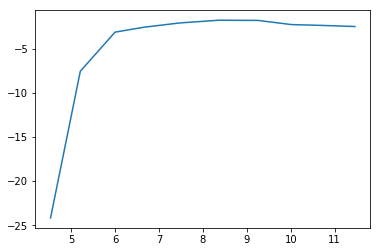

In [12]:
plt.plot(time, elbo)


In [13]:
component_parameters_flat1 = []
_ = [component_parameters_flat1.extend(x) for x in component_parameters]
component_parameters_flat = []
_ = [component_parameters_flat.extend(x) for x in component_parameters_flat1]

learned_components = model.components
learned_posteriors = [comp.posterior for comp in learned_components]
dimensionality = all_data[0].shape[1]
learned_natural_params = [post.natural_params.reshape((-1,dimensionality)) for post in learned_posteriors]
learned_means = [ n[1]/n[2] for n in learned_natural_params ]
learned_vars = [ (n[0]-((n[1]**2)/n[2]))/(n[3]+1) for n in learned_natural_params ]
print(learned_means)
print(learned_vars)


[array([ -4.16846389e-01,  -2.32688209e+00,  -2.26191937e-01,
        -2.71079709e-02,  -3.57787772e-01,  -2.07072212e-01,
        -2.76046030e-02,  -1.79141338e-02,  -5.52369856e-02,
        -4.22405715e-01,  -1.17537536e-01,  -4.71177275e-01,
        -5.90303279e-01,   1.51673220e-03,  -3.22635611e-01]), array([-0.32065816,  0.20424453, -0.24431471, -0.30081085, -0.31558699,
       -0.25459809, -0.44461943, -0.45025195,  0.34567759, -0.16888401,
       -0.25003584, -0.56576784,  0.1067349 ,  0.00258493,  0.42155078]), array([ 0.31416615, -0.02844454, -0.0556016 ,  0.08716659, -0.06318118,
       -0.30257868, -0.08725539, -0.11278527, -0.10301787,  0.56628889,
       -0.08381904, -0.11607657,  0.46622907,  0.46089588,  0.26411342]), array([ 0.61761306,  0.20154537,  0.17968061, -0.3747038 ,  0.17142467,
       -0.3297094 ,  0.34626467,  0.0842105 ,  0.40990812,  0.23785105,
       -0.02028305,  0.46012733, -0.0710114 , -0.44986814, -0.11750057]), array([ -3.90653339e-01,  -2.19305824e

30
54
45
54
[array([ -4.16846389e-01,  -2.32688209e+00,  -2.26191937e-01,
        -2.71079709e-02,  -3.57787772e-01,  -2.07072212e-01,
        -2.76046030e-02,  -1.79141338e-02,  -5.52369856e-02,
        -4.22405715e-01,  -1.17537536e-01,  -4.71177275e-01,
        -5.90303279e-01,   1.51673220e-03,  -3.22635611e-01]), array([-0.32065816,  0.20424453, -0.24431471, -0.30081085, -0.31558699,
       -0.25459809, -0.44461943, -0.45025195,  0.34567759, -0.16888401,
       -0.25003584, -0.56576784,  0.1067349 ,  0.00258493,  0.42155078]), array([ 0.31416615, -0.02844454, -0.0556016 ,  0.08716659, -0.06318118,
       -0.30257868, -0.08725539, -0.11278527, -0.10301787,  0.56628889,
       -0.08381904, -0.11607657,  0.46622907,  0.46089588,  0.26411342]), array([ 0.61761306,  0.20154537,  0.17968061, -0.3747038 ,  0.17142467,
       -0.3297094 ,  0.34626467,  0.0842105 ,  0.40990812,  0.23785105,
       -0.02028305,  0.46012733, -0.0710114 , -0.44986814, -0.11750057]), array([ -3.90653339e-01,  

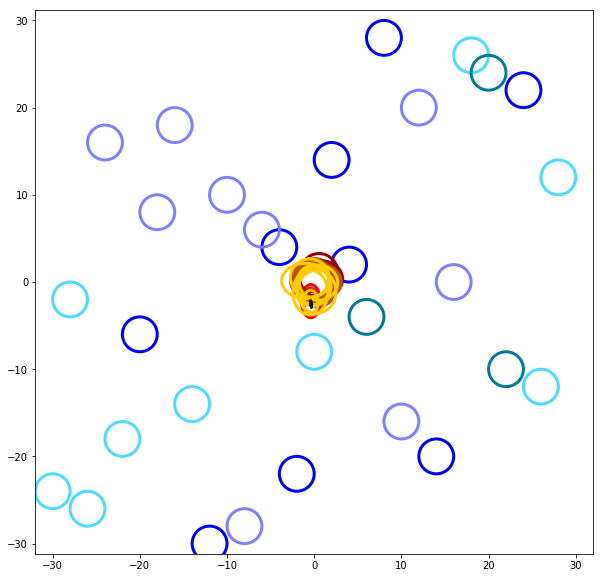

In [15]:


def gaussian_2d(x, y, dist):
    return dist.pdf([x,y])

gaussian_2d_v = np.vectorize(gaussian_2d)

# Based on code from joferkington at 
# https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = matplotlib.patches.Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# if __name__ == '__main__':
#     #-- Example usage -----------------------
#     # Generate some random, correlated data
#     points = np.random.multivariate_normal(
#             mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000
#             )
#     # Plot the raw points...
#     x, y = points.T
#     plt.plot(x, y, 'ro')

#     # Plot a transparent 3 standard deviation covariance ellipse
#     plot_point_cov(cov=cov, mean=mean, nstd=2, alpha=0.5, color='green')

#     plt.show()


def plot_gauss_2d(mean, cov, xlim=(-2.0, 2.0), ylim=(-2.0, 2.0), color='k'):
#     mv = multivariate_normal(mean=mean, cov=cov)
    plot_cov_ellipse(cov=cov, pos=mean, nstd=2, fill=False, lw=3, color=color)
#     x = np.linspace(*xlim)
#     y = np.linspace(*ylim)
#     X, Y = np.meshgrid(x, y)
#     Z = gaussian_2d_v(X, Y, mv)
#     CS = plt.contour(X, Y, Z, 2, colors=colors)
    #fmt = {CS.levels[0]: '95%', CS.levels[1]: '99%'}
    #plt.clabel(CS, fmt=fmt)
    
plt.figure(figsize=(10, 10))
plt.axis('equal')
axes = plt.gca()
axes.set_xlim([-32,32])
axes.set_ylim([-32,32])

# plot_gauss_2d(mean=[0,1], cov=[[1,0.5],[0.5,1]])
# plot_gauss_2d(mean=[1,0], cov=[[1,-0.5],[-0.5,1]])

component_parameters

def list_repeat(given_list, repeat_factor):
    return_list = []
    for item in given_list:
        return_list.extend([item]*repeat_factor)
    return return_list


colors_given_list = ['#0000ff', '#8080ff', '#4ddbff', '#007a99', '#00cc00', '#008000']
colors_learned_list = ['#ff0000', '#990000', '#ff9933', '#b35900', '#ffcc00', '#ff6633']


colors_given = list_repeat(colors_given_list, n_states*n_comp_per_state)
colors_learned = list_repeat(colors_learned_list, n_states*n_comp_per_state)


print(len(component_parameters_flat))
print(len(colors_given))
print(len(learned_means))
print(len(colors_learned))

print(learned_means)
print(learned_vars)



# Plot gaussians used to generate data
_ = [ plot_gauss_2d(mean=comp[0], cov=comp[1], xlim=xlim, ylim=ylim, color=color) for comp, color in zip(component_parameters_flat, colors_given)]

# Plot gaussians learned from data
_ = [ plot_gauss_2d(mean=mean, cov=[[var[0],0],[0,var[1]]], xlim=xlim, ylim=ylim, color=color) for mean, var, color in zip(learned_means, learned_vars, colors_learned)]

# Plot data
for mfccs in all_data:
    plt.plot(mfccs[:,0], mfccs[:,1], color='#00000033', marker='o',  linestyle='none', markersize=2)